<a href="https://colab.research.google.com/github/DhruvArora96/Hands-On/blob/master/end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
################LOADING DATA############################################

In [2]:
import pandas as pd
housing_url = "https://raw.githubusercontent.com/DhruvArora96/Hands-On/master/datasets/housing/housing.csv" 
housing_data = pd.read_csv(housing_url)

In [3]:
housing=housing_data.copy()

In [4]:
import hashlib
import numpy as np
def test_set_check(identifier, test_ratio, hash):
  return hash(np.int64(identifier)).digest()[-1]<256*test_ratio
def split_train_test_by_id(data, test_ratio, id_column,hash=hashlib.md5):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio,hash))
  return data.loc[~in_test_set],data.loc[in_test_set]


In [5]:
housing_with_id=housing.reset_index()
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [6]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing,test_size=0.2,random_state=42)

In [7]:
#reducing the number of strate
import numpy as np
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)

In [8]:
#sampling based on income
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):
  strat_train_set=housing.loc[train_index]
  strat_test_set=housing.loc[test_index]

In [9]:
for set in (strat_train_set,strat_test_set):
  set.drop(["income_cat"],axis=1,inplace=True)

In [10]:
housing = strat_train_set.copy()

In [14]:
import matplotlib.pyplot as plt

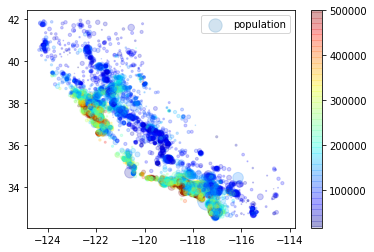

In [15]:
plt.scatter(housing["longitude"],housing["latitude"],alpha=0.2,s=housing["population"]/100,label="population",c=housing["median_house_value"],cmap=plt.get_cmap("jet"))
plt.legend()
plt.colorbar()

In [16]:
corr_matrix=housing.corr()

In [17]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5B643E248>,
      dtype=object)

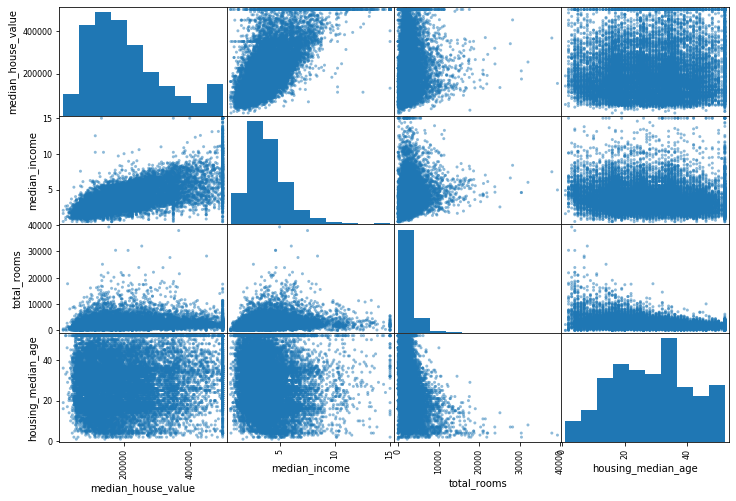

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

In [19]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [20]:
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [21]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [22]:
################# DATA CLEANING ##################################################

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [24]:
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [25]:
X = imputer.transform(housing_num)

In [26]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [27]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
np.unique(housing_cat_encoded)

array([0, 1, 2, 3, 4])

In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

c:\users\dhruv\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [29]:
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix, bedrooms_ix,population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
  def __init__(self,add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    rooms_per_household = X [:,rooms_ix]/X[:,households_ix]
    population_per_household = X[:,population_ix]/X[:,households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
      return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]

In [30]:
#############Transformation Pipeline##########################################

In [31]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
  def __init__(self,attribute_names):
    self.attribute_names = attribute_names
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    return X[self.attribute_names].values


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
                 ('selector',DataFrameSelector(num_attribs)),                
                 ('imputer',SimpleImputer(strategy ="median")),
                 ('attribs_adder', CombinedAttributesAdder()),
                 ('std_scaler',StandardScaler()),
])
cat_pipeline = Pipeline([
                 ('selector',DataFrameSelector(cat_attribs)),
                 ('one_hot_encoder',OneHotEncoder(sparse = False)),
])


In [33]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list = [
                                            ("num_pipeline",num_pipeline),
                                            ("cat_pipeline",cat_pipeline),
                                            ])

In [35]:
housing_prep = full_pipeline.fit_transform(housing)
housing_prep.shape

(16512, 16)

In [36]:
################ Trainning the model ####################

In [37]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prep,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [39]:
some_data_prep = full_pipeline.transform(some_data)

In [40]:
print("Predictions:",lin_reg.predict(some_data_prep))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [41]:
print("Labels:",list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [42]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prep)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [ ]:
from sklearn.tree import DecisionTreeRegressor
